In [ ]:
"""
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

# Gen Media end-to-end Workflow, Virtual Try-on usecase

This Jupyter Notebook outlines a complete, scalable pipeline for generating diverse, photorealistic virtual try-on. The core objective is to use a suite of Google's Generative AI models—Gemini (for orchestration and critique), Gemini Image Generation (for creating diverse base models), Vertex AI Virtual Try-On (VTO) (for garment swapping), and Veo (for adding motion)—to produce a large volume of Virtual Try-On images and short motion videos featuring diverse digital models in various outfits. All these are creatd using one platform Vertex AI!

Created on 11/12/2025

#Imports and Dependencies

Below cell includes all necessary standard library (e.g., os, sys, re), third-party (pandas, PIL), and Google Cloud (google.genai, google.cloud.storage) imports required to run the workflow.


*   Import standard Python libraries for file operations, regular expressions, data handling, and time.
*   Import third-party libraries like pandas for data manipulation and PIL (Pillow) for image processing.
*   Import Google Cloud libraries for interacting with Google Cloud Storage (storage) and Vertex AI (PredictionServiceClient).
*   Import Google Generative AI SDK components (google.genai, types) to interface with Gemini and Veo models.

In [ ]:
# Imports
import base64
import concurrent.futures
import csv
import datetime as dt
import io
import json
import os
import re
import sys
import time
import timeit
import uuid
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed, wait
from typing import Dict, List, Optional, Tuple

# Third-party
import pandas as pd

# Google Cloud & GenAI
from google import genai
from google.cloud import storage
from google.cloud.aiplatform.gapic import PredictionServiceClient
from google.genai import types
from google.genai.types import (
    GenerateContentConfig,
    GenerateVideosConfig,
)
from google.genai.types import Image as GenAIImage
from google.genai.types import (
    Modality,
    Part,
)
from IPython.display import HTML, display
from PIL import Image, ImageFile

print("Imports complete.")

Imports complete.


# Update for model changes happens here

All configurable parameters (Project ID, Bucket Names, Model Versions, Paths) are centralized here. Standardized the bucket variable to BUCKET_NAME across the script.


*   List itemCentralize all configurable parameters, including Google Cloud Project ID and location.List item
*   Define GCS bucket details and file path prefixes for managing various assets (model images, outfit images, VTO outputs, and final videos).
*   Specify the exact model versions
*   Initialize the necessary Python clients for Google Cloud Storage and the Generative AI API.







In [ ]:
# Global Configuration, UPDATE FOR ANY MODEL CHANGES
# --- Project & Location Settings ---
# Ensure these match your environment
os.environ["GOOGLE_CLOUD_PROJECT"] = (
    "consumer-genai-experiments"  # update your project
)
os.environ["GOOGLE_CLOUD_LOCATION"] = "us-central1"  # update your location

PROJECT_ID = os.environ.get("GOOGLE_CLOUD_PROJECT")
LOCATION = os.environ.get("GOOGLE_CLOUD_LOCATION")
GENAI_LOCATION = "us-central1"  # or "global" depending on availability

# --- Storage Configuration ---
BUCKET_NAME = "lj-revolve"  # Standardized bucket name , update your bucket name

# GCS Paths/Prefixes -> The process will create the subsequent file and folder structure
CSV_OBJECT_NAME = "Model_Creation.csv"
MODELS_PREFIX = "models"  # Base images of models
OUTFITS_PREFIX = "Dress"  # Input dress images
VTO_OUTPUT_PREFIX = "Dress/4tryon"
FINAL_PREFIX = "Dress/4tryon/final"
MOTION_OUTPUT_PREFIX = "Dress/4tryon/final_motion"

# --- Model Versions ---
# Text/Orchestration Model
MODEL_TEXT = "gemini-2.5-flash"

# Image Generation Model
MODEL_IMAGE_GEN = "gemini-2.5-flash-image"

# Virtual Try-On (Vertex AI)
MODEL_ID_VTO = "virtual-try-on-preview-08-04"

# Video Generation (Veo)
MODEL_VIDEO = "veo-3.0-generate-001"

# --- Execution Parameters ---
NUM_MODELS_TO_GENERATE = 5
PARALLEL_JOBS_PER_MODEL = 10
VTO_VARIATIONS = 4  # Number of images per try-on

# Initialize Global Clients
storage_client = storage.Client(project=PROJECT_ID)
genai_client = genai.Client(
    vertexai=True, project=PROJECT_ID, location=GENAI_LOCATION
)

print(f"Configuration Set: Project={PROJECT_ID}, Bucket={BUCKET_NAME}")

Configuration Set: Project=consumer-genai-experiments, Bucket=lj-revolve


#Use Case 1 - Model Definitions (CSV Generation)

Description: Logic to generate the CSV file containing diverse model prompts.

- Define a comprehensive list of diversity parameters (Ethnicity, Age, Skin Tone, Body Type, Hair Style).

- Define a rigid output structure (JSON Schema) to ensure the model's response is machine-readable and includes Title, Distinctive Traits, and the full image Description.

- Use Gemini Flash (orchestration model) with a constrained output schema to generate NUM_MODELS_TO_GENERATE (e.g., 5) unique, diverse model prompts.

Convert the structured response into a raw CSV string.

- Upload the Model_Creation.csv file containing the generated prompts to GCS.

In [ ]:
# ===== Diversity Parameters and Template =====
DIVERSITY_INSTRUCTIONS = """
Ethnicity: African American, Afro-Caribbean, East African, West African, East Asian, South Asian, Southeast Asian, Middle Eastern,
Pacific Islander, Native American, Indigenous Australian, Caucasian, Eastern European, Irish, Mixed-race, Inuit.
Age: young adult, adult, middle-aged, elderly.
Skin Tone: porcelain, fair, olive, tan, golden-brown, caramel, deep brown, ebony, cool beige, dusky.
Body Type: petite, athletic, curvy, plus-size, triple-plus-size, tall and lean, average, full-figured, slender, compact, statuesque.
Hair Style: long black hair, short natural curls, long blonde hair, wavy brown hair, shoulder-length black hair, auburn hair, long red hair,
straight dark hair, natural curls, short silver hair, tightly coiled short hair.

The full description template is:
"A full-body studio photo of a {age} {ethnicity} woman with {skin} skin and a {body} build {hair_clause}.
Outfit: plain white shirt, blue jeans, and white sneakers (same style for all). Background: plain white; neutral lighting; front-facing; natural posture; no accessories, logos, text, or props."
The {hair_clause} must be derived from the 'Hair Style' list and formatted as ', [hair style]'.
"""

CSV_SCHEMA = types.Schema(
    type=types.Type.ARRAY,
    description=f"A list of {{NUM_MODELS_TO_GENERATE}} unique model definitions.",  # Placeholder replacement for demonstration
    items=types.Schema(
        type=types.Type.OBJECT,
        properties={
            "Title": types.Schema(
                type=types.Type.STRING,
                description="A brief title, e.g., 'Plus-Size East Asian Woman'.",
            ),
            "Distinctive Traits": types.Schema(
                type=types.Type.STRING,
                description="A summary of the model's traits.",
            ),
            "Description": types.Schema(
                type=types.Type.STRING,
                description="The full, detailed text prompt following the template provided.",
            ),
        },
        required=["Title", "Distinctive Traits", "Description"],
    ),
)


def generate_csv_data_with_gemini(n_rows: int) -> tuple[str, str]:
    """
    Generates diverse model prompts and returns both the raw CSV string
    and a formatted Markdown table string.
    """
    system_instruction = (
        "You are an expert prompt engineer generating a diverse list of models for "
        "AI image creation. You must strictly adhere to the provided lists and template. "
        "The goal is to maximize diversity across all listed categories for each of the "
        f"{n_rows} rows. Provide the final output as a CSV string."
    )
    prompt = (
        f"Generate {n_rows} unique, diverse entries for image generation prompts. "
        "Each entry must strictly select characteristics from the following lists:\n\n"
        f"{DIVERSITY_INSTRUCTIONS}\n\n"
        "Generate the data in a CSV format with the following columns: 'Title', 'Distinctive Traits', 'Description'."
    )

    response = genai_client.models.generate_content(
        model=MODEL_TEXT,
        contents=[prompt],
        config=types.GenerateContentConfig(
            system_instruction=system_instruction,
            response_mime_type="application/json",
            response_schema=CSV_SCHEMA,
            temperature=0.7,
        ),
    )

    data = pd.read_json(io.StringIO(response.text))

    # 1. Generate Raw CSV text (for upload)
    csv_buf = io.StringIO()
    data.to_csv(csv_buf, index=False, encoding="utf-8")
    csv_text = csv_buf.getvalue()

    # 2. Generate Markdown Table text (for display)
    markdown_text = data.to_markdown(index=False, tablefmt="simple")

    return csv_text, markdown_text


def upload_csv_text_to_gcs(csv_text: str):
    blob = storage_client.bucket(BUCKET_NAME).blob(CSV_OBJECT_NAME)
    blob.upload_from_string(csv_text, content_type="text/csv; charset=utf-8")
    print(f"[OK] Uploaded CSV to gs://{BUCKET_NAME}/{CSV_OBJECT_NAME}")


# Execution
csv_text, table_text = generate_csv_data_with_gemini(NUM_MODELS_TO_GENERATE)
# --- Display the results in table format ---
print("Generated Model Prompts")
print(table_text)
# --- Upload the original CSV text to GCS ---
upload_csv_text_to_gcs(csv_text)

Generated Model Prompts
Title                                              Distinctive Traits                                                                 Description
-------------------------------------------------  ---------------------------------------------------------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Young East Asian Woman with Long Black Hair        Young adult, East Asian, fair skin, slender build, long black hair                 A full-body studio photo of a young adult East Asian woman with fair skin and a slender build, long black hair. Outfit: plain white shirt, blue jeans, and white sneakers (same style for all). Background: plain white; neutral lighting; f

#Use Case 2 - Model Image Generation

Description: Reads the CSV generated in the previous step and uses Gemini Image Generation aka Nano Banana to create the base model images.

- Define the STYLE_INSTRUCTION to maintain a consistent look for all models (e.g., specific white t-shirt, black jeans, white background).

- Read the Model_Creation.csv file from GCS into a DataFrame.

- Iterate through each model prompt (Description) from the CSV.

- Combine the fixed STYLE_INSTRUCTION and the diverse Description into a final image generation prompt.

- Call the Gemini Image Generation Model (Nano Banana) to create a full-body image for each diverse model.

- Upload each generated image to GCS under the models prefix.

- Display the generated images directly in the notebook.


[Start] Generating Models from CSV...

[Total] Generated & uploaded: 5 image(s).

[Display] Displaying generated images in a row...



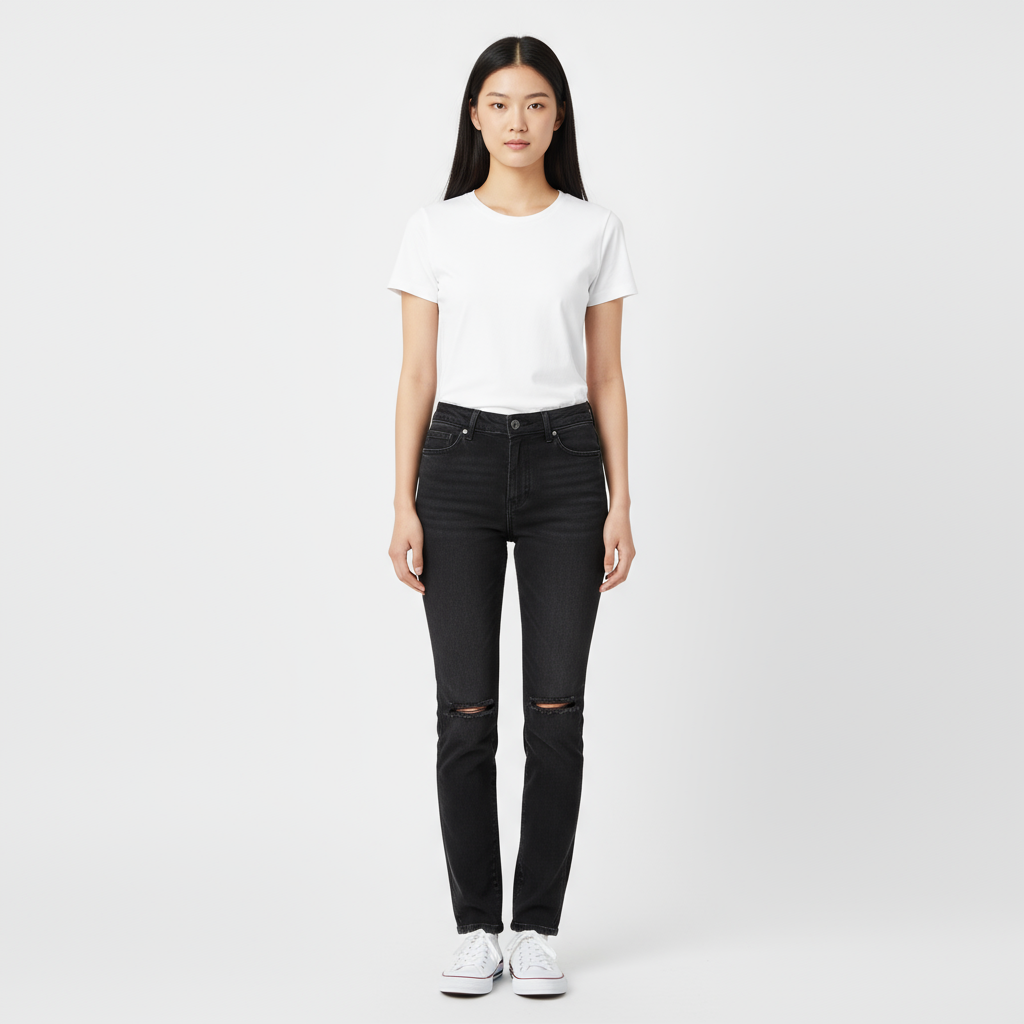
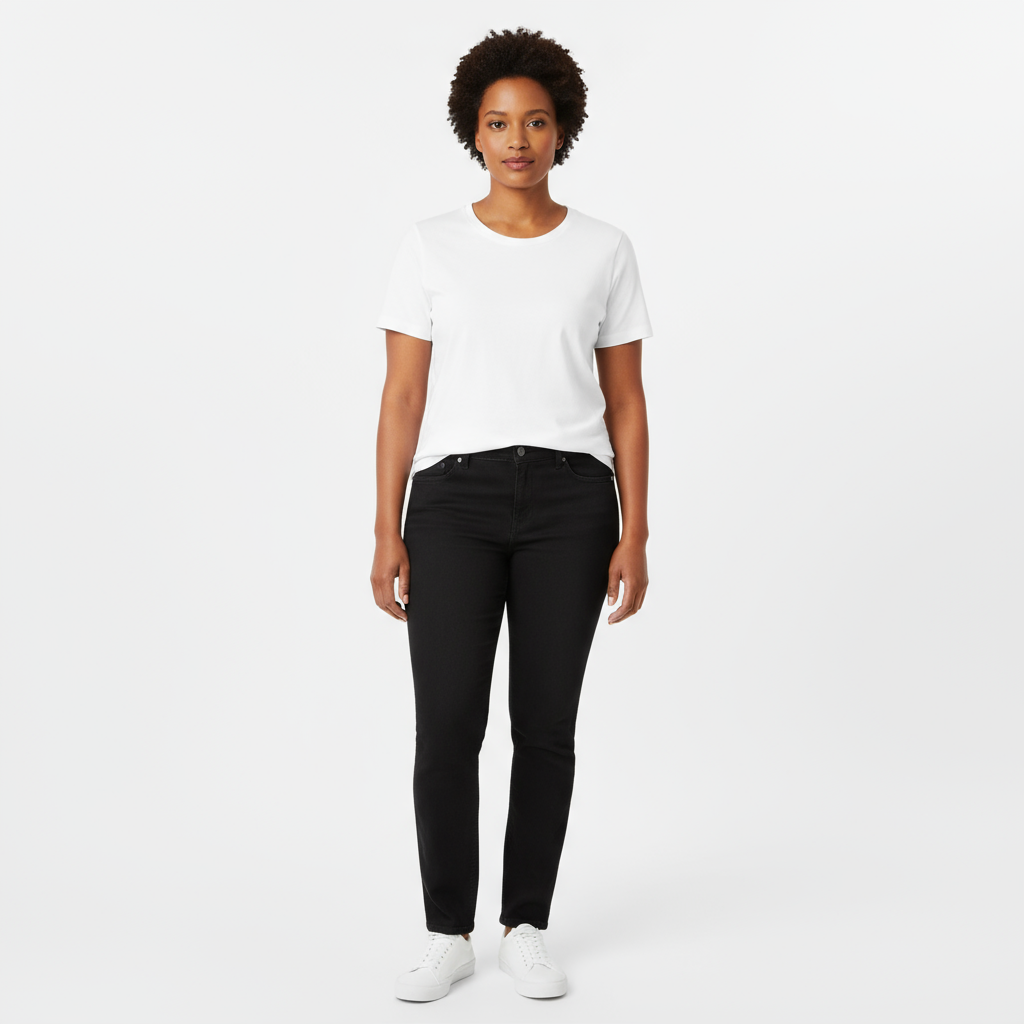
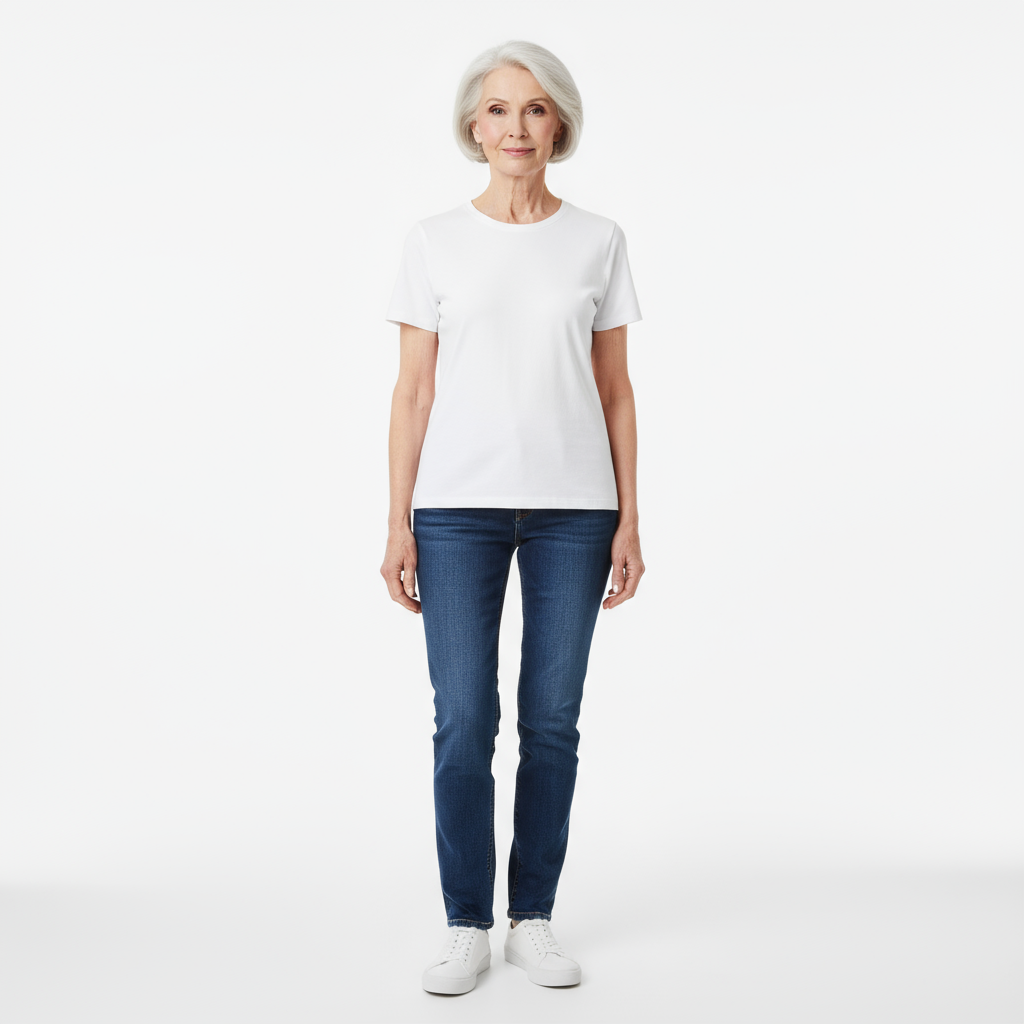
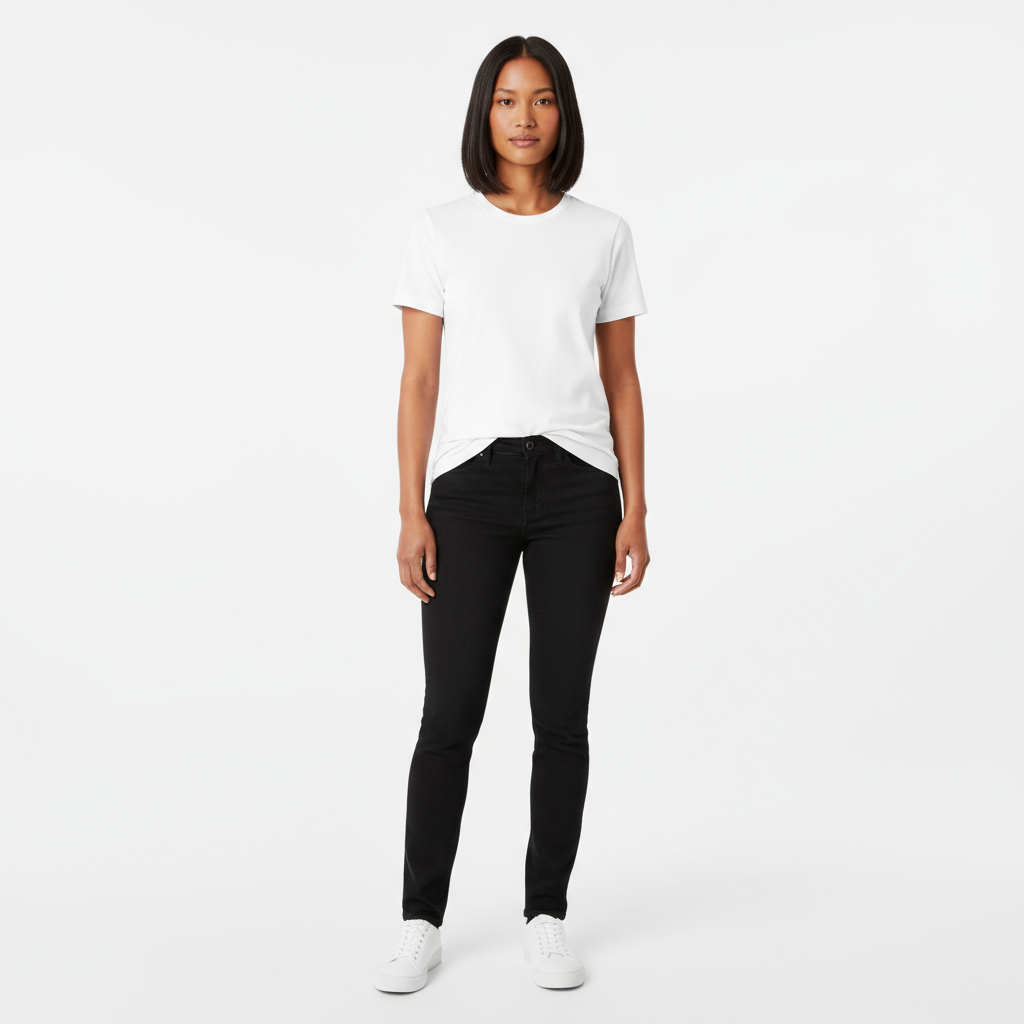
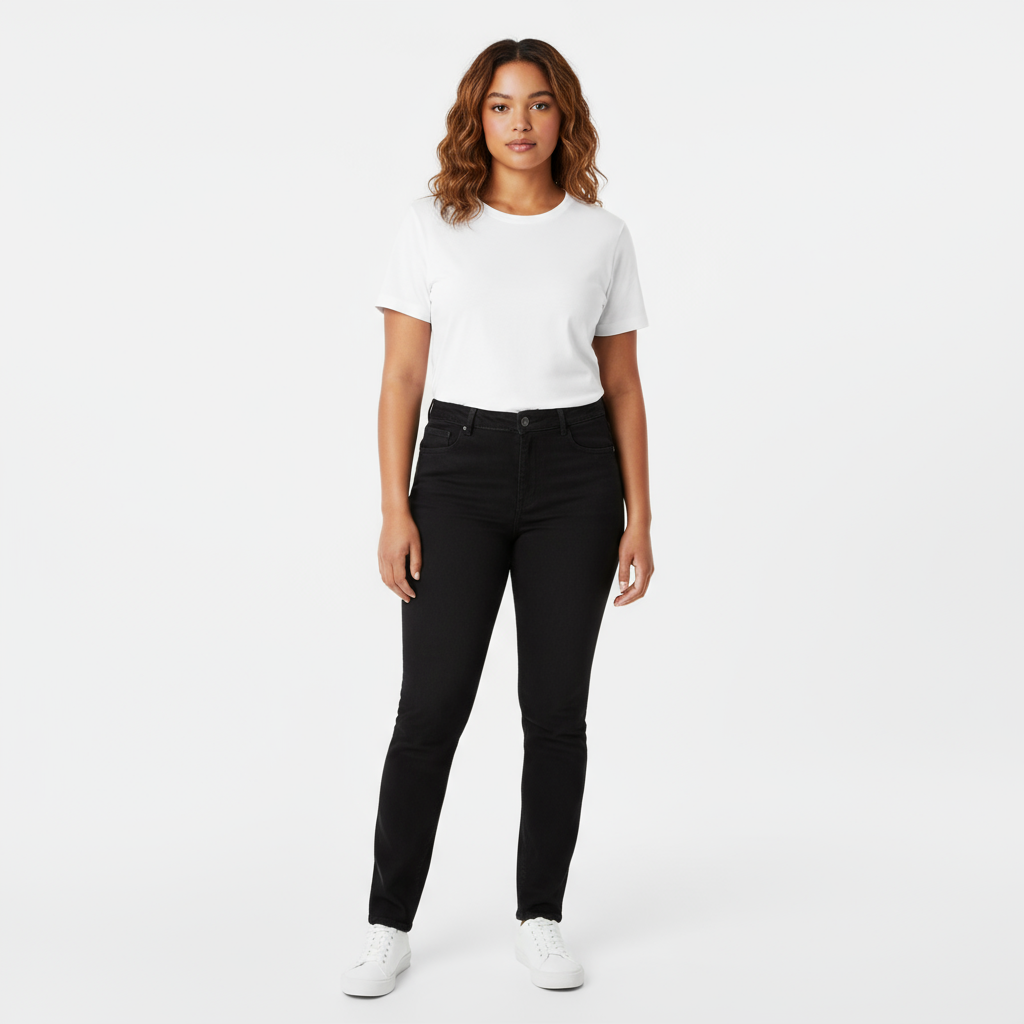

In [ ]:
PROMPT_COLUMN = "Description"
IDENTIFIER_COLUMNS = ["Title"]

STYLE_INSTRUCTION = (
    "Render a full-body studio photo of the described person with the following fixed styling:\n"
    "- Outfit: plain white round neck t-shirt, classic black jeans, and white casual sneakers.\n"
    "- IMPORTANT :same style for every model, keep the t-shirt completly inserted.\n"
    "- Styling: Make sure all models are styled the same way.\n"
    "- Background: plain solid white background, no props, no text.\n"
    "- Lighting: neutral and even; avoid hard shadows.\n"
    "- Pose: simple front-facing stance; natural posture; no accessories or logos.\n"
    "- Keep the person’s body type, skin tone, age, and ethnicity exactly as described below.\n"
)


def read_csv_gs(bucket, object_name) -> pd.DataFrame:
    blob = storage_client.bucket(bucket).blob(object_name)
    data = blob.download_as_bytes()
    return pd.read_csv(io.BytesIO(data))


def sanitize(s: str) -> str:
    clean = (
        "".join(ch if ch.isalnum() else "_" for ch in str(s)).strip("_").lower()
    )
    while "__" in clean:
        clean = clean.replace("__", "_")
    return clean[:64] or "image"


def gen_image_bytes(prompt_text: str) -> Optional[bytes]:
    try:
        resp = genai_client.models.generate_content(
            model=MODEL_IMAGE_GEN,
            contents=(prompt_text,),
            config=GenerateContentConfig(
                response_modalities=[Modality.TEXT, Modality.IMAGE]
            ),
        )
        for part in resp.candidates[0].content.parts:
            if part.inline_data and part.inline_data.data:
                return part.inline_data.data
        return None
    except Exception as e:
        print(f"  [ERROR] Generation failed: {e}")
        return None


def upload_png(image_bytes: bytes, stem: str) -> str:
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    uid = uuid.uuid4().hex[:8]
    name = f"{MODELS_PREFIX}/{sanitize(stem)}_stdfit_{ts}_{uid}.png"
    blob = storage_client.bucket(BUCKET_NAME).blob(name)
    blob.upload_from_string(image_bytes, content_type="image/png")
    # Return the GCS URI
    return f"gs://{BUCKET_NAME}/{name}"


# ---  FUNCTION FOR DISPLAY ---
def display_images_in_row(
    gcs_uris: list[str], bucket_name: str, total_cols: int = 5
):
    """
    Displays images side-by-side in a Colab notebook by downloading image bytes
    from GCS and embedding them directly in HTML using Base64 encoding.
    This bypasses all Public Access Prevention and Signed URL issues.
    """
    if not gcs_uris:
        print("No images to display.")
        return

    container_width = 100 / total_cols
    images_html = []

    for uri in gcs_uris:
        try:
            # 1. Extract the blob name
            blob_name = uri.replace(f"gs://{bucket_name}/", "")
            blob = storage_client.bucket(bucket_name).blob(blob_name)

            # 2. Download the image bytes directly
            image_bytes = blob.download_as_bytes()

            # 3. Encode the bytes as Base64 for HTML embedding
            encoded_image = base64.b64encode(image_bytes).decode("utf-8")

            # 4. Create the Data URI
            data_uri = f"data:image/png;base64,{encoded_image}"

            # Create HTML for one image container
            img_html = f"""
            <div style="width: {container_width}%; box-sizing: border-box; padding: 5px; text-align: center;">
                <img src="{data_uri}" style="width: 100%; height: auto; border: 1px solid #ccc;"/>
            </div>
            """
            images_html.append(img_html)

        except Exception as e:
            print(f"  [ERROR] Failed to process or display {uri}: {e}")

    # Combine all image containers into a single row
    full_html = f"""
    <div style="display: flex; flex-direction: row; flex-wrap: nowrap; overflow-x: auto; width: 100%;">
        {''.join(images_html)}
    </div>
    """

    display(HTML(full_html))


# --- Execution ---
print(f"\n[Start] Generating Models from CSV...")
try:
    df = read_csv_gs(BUCKET_NAME, CSV_OBJECT_NAME)

    num_models = (
        NUM_MODELS_TO_GENERATE
        if "NUM_MODELS_TO_GENERATE" in locals()
        else len(df)
    )
    df = df.head(num_models)

    generated_uris = []
    for i, row in df.iterrows():
        title = str(row.get("Title", f"row_{i+1}")).strip()
        desc = row.get(PROMPT_COLUMN)

        stem = f"model_{sanitize(title)}"
        prompt_text = f"{STYLE_INSTRUCTION}\n--- Person Description ---\n{desc}"

        img = gen_image_bytes(prompt_text)
        if img:
            uri = upload_png(img, stem)
            generated_uris.append(uri)
        else:
            print("  [Fail] No image generated.")

    print(f"\n[Total] Generated & uploaded: {len(generated_uris)} image(s).")

    # ---  DISPLAY CALL ---
    print("\n[Display] Displaying generated images in a row...")
    display_images_in_row(
        generated_uris, BUCKET_NAME, total_cols=len(generated_uris)
    )

except Exception as e:
    print(f"[FATAL ERROR] {e}")

#Use Case 3 - Virtual Try-On (Vertex AI VTO)

Description: Multi-try-on in one shot using the Vertex AI VTO API
- The process involves pairing the generated model images (from Step 4) with input outfit images (from the GCS Dress prefix).

- Use a ThreadPoolExecutor to orchestrate the VTO generation in parallel for multiple model/outfit pairs.

- Call the Vertex AI VTO Model  for each pair, generating a defined number of candidate try-on images (VTO_VARIATIONS = 4).

In [23]:
# Helper Functions


def b64(data: bytes) -> str:
    return base64.b64encode(data).decode("utf-8")


def list_top_level_pngs(bucket_name, prefix) -> List[str]:
    blobs = storage_client.list_blobs(
        bucket_name, prefix=prefix if prefix.endswith("/") else prefix + "/"
    )
    names = [
        b.name
        for b in blobs
        if b.name.lower().endswith(".png")
        and "/" not in b.name[len(prefix) + 1 :]
    ]
    names.sort()
    return names


def pil_from_prediction(pred) -> Image.Image:
    encoded = pred["bytesBase64Encoded"]
    return Image.open(io.BytesIO(base64.b64decode(encoded))).convert("RGB")


def call_virtual_try_on_4(
    person_b64: str, outfit_b64: str
) -> List[Image.Image]:
    client = PredictionServiceClient(
        client_options={"api_endpoint": f"{LOCATION}-aiplatform.googleapis.com"}
    )
    instances = [
        {
            "personImage": {"image": {"bytesBase64Encoded": person_b64}},
            "productImages": [{"image": {"bytesBase64Encoded": outfit_b64}}],
        }
    ]

    params = {"experimentalMode": "exp-08-04", "sampleCount": VTO_VARIATIONS}
    resp = client.predict(
        endpoint=f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/{MODEL_ID_VTO}",
        instances=instances,
        parameters=params,
    )
    return [pil_from_prediction(p) for p in resp.predictions]


def tryon_worker(
    model_name: str, person_b64: str, outfit_path: str, retries: int = 3
):
    outfit_name = os.path.splitext(os.path.basename(outfit_path))[0]

    for attempt in range(1, retries + 1):
        try:
            outfit_bytes = (
                storage_client.bucket(BUCKET_NAME)
                .blob(outfit_path)
                .download_as_bytes()
            )
            imgs = call_virtual_try_on_4(person_b64, b64(outfit_bytes))

            # Save each candidate PNG
            for idx, img in enumerate(imgs):
                buf = io.BytesIO()
                img.save(buf, format="PNG")
                out_rel = f"{VTO_OUTPUT_PREFIX}/{model_name}_TRYON4_{outfit_name}_C{idx+1}.png"
                storage_client.bucket(BUCKET_NAME).blob(
                    out_rel
                ).upload_from_string(buf.getvalue(), content_type="image/png")

            print(f"[DONE] {model_name} x {outfit_name}")
            return True  # success, stop retry loop

        except Exception as e:
            print(
                f"[ERROR] {model_name} x {outfit_name} (attempt {attempt}): {e}"
            )
            if attempt == retries:
                print(
                    f"[FAIL] {model_name} x {outfit_name} failed after {retries} attempts."
                )
                return False  # failed after all retries


# Execution
print(f"\n[START VTO] Vertex AI ")
outfit_paths = list_top_level_pngs(BUCKET_NAME, OUTFITS_PREFIX)
model_paths = list_top_level_pngs(BUCKET_NAME, MODELS_PREFIX)

for model_path in model_paths:
    model_name = os.path.splitext(os.path.basename(model_path))[0]

    try:
        person_bytes = (
            storage_client.bucket(BUCKET_NAME)
            .blob(model_path)
            .download_as_bytes()
        )
        person_b64 = b64(person_bytes)

        # 1st pass
        failed = []
        with ThreadPoolExecutor(
            max_workers=min(PARALLEL_JOBS_PER_MODEL, len(outfit_paths))
        ) as ex:
            futures = {
                ex.submit(tryon_worker, model_name, person_b64, p): p
                for p in outfit_paths
            }
            for fut in as_completed(futures):
                if fut.result() is False:
                    failed.append(futures[fut])

        # Retry only failed outfits
        if failed:
            print(
                f"\n[RETRY PASS] Re-running {len(failed)} failed outfits for {model_name}..."
            )
            with ThreadPoolExecutor(
                max_workers=min(PARALLEL_JOBS_PER_MODEL, len(failed))
            ) as ex:
                futures = [
                    ex.submit(tryon_worker, model_name, person_b64, p)
                    for p in failed
                ]
                for fut in as_completed(futures):
                    fut.result()

    except Exception as e:
        print(f"[WARN] Failed processing model {model_path}: {e}")

print(f"[DONE] Outputs in: gs://{BUCKET_NAME}/{VTO_OUTPUT_PREFIX}")


[START VTO] Vertex AI 
[DONE] model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4 x dress4
[DONE] model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4 x dress3
[DONE] model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4 x dress1
[DONE] model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4 x dress2
[DONE] model_elderly_caucasian_woman_petite_silver_hair_stdfit_20251111_223840_932165b8 x dress3
[DONE] model_elderly_caucasian_woman_petite_silver_hair_stdfit_20251111_223840_932165b8 x dress4
[DONE] model_elderly_caucasian_woman_petite_silver_hair_stdfit_20251111_223840_932165b8 x dress2
[DONE] model_elderly_caucasian_woman_petite_silver_hair_stdfit_20251111_223840_932165b8 x dress1
[DONE] model_middle_aged_afro_caribbean_woman_full_figured_stdfit_20251111_223833_606d9892 x dress1
[DONE] model_middle_aged_afro_caribbean_woman_full_figured_stdfit_20251111_22383

#Use Case 4 - AI Critique & Selection

Description: Uses Gemini Flash to critique the 4 generated options and select the best one based on realism, fidelity, and artifact checking. Creates Evluation Summary with reason for the final pick.
- Collect and group all VTO candidate images, ensuring exactly 4 candidates exist for each model/outfit combination.

- Define the judge function that uses the Gemini Text Model (gemini flash) for a multi-modal critique.

- The function inputs the original model image, the original outfit image, and the four VTO candidate images to the model.

- The model determines the best image based on the quality of the try-on, realism, and adherence to the model's identity.

- Execute the critique process in parallel using a ThreadPoolExecutor.

- The winning image for each model/outfit combination is copied to the final GCS folder (Dress/4tryon/final).

In [45]:
print("[START] AI Critique")

bucket = storage_client.bucket(BUCKET_NAME)

# --------- 1) Candidate Filename Pattern ---------
CAND_RE = re.compile(
    r"^(?P<modelStamp>.+?)_TRYON4(?:_)?(?P<outfit>.+?)_C(?P<cid>[1-4])\.png$",
    re.IGNORECASE,
)

# --------- 2) Prompt ---------


def build_critique_prompt(outfit, model_stamp):
    return (
        f"**Target Outfit:** {outfit}\n"
        f"**Target Model:** {model_stamp}\n\n"
        "You are a strict and highly critical visual judge for Virtual Try-On (VTO) quality.\n"
        "Select the SINGLE best try-on result where the outfit is transferred cleanly.\n"
        "The winning candidate MUST NOT show any part of the model's original clothing.\n"
        "The winning candidate MUST have both legs with shoe on.\n"
        "Judge based on: Garment Fidelity, Fit Realism, Clarity, and Lack of Artifacts.\n\n"
        "Return JSON only:\n"
        "{ 'scores': { ... }, 'winner': 'C1|C2|C3|C4', 'reason_short': '...' }"
    )


# --------- 3) Judge function ---------


def judge(cpaths, model_path, outfit_path):
    b = storage_client.bucket(BUCKET_NAME)

    prompt = build_critique_prompt(
        os.path.basename(outfit_path), os.path.basename(model_path)
    )

    parts = [prompt]

    # Candidate images C1..C4 (correct Part.from_bytes signature)
    for key in ("C1", "C2", "C3", "C4"):
        parts.append(
            Part.from_bytes(
                mime_type="image/png",
                data=b.blob(cpaths[key]).download_as_bytes(),
            )
        )

    # Reference model image
    parts.append(
        Part.from_bytes(
            mime_type="image/png", data=b.blob(model_path).download_as_bytes()
        )
    )

    # Reference outfit image
    parts.append(
        Part.from_bytes(
            mime_type="image/png", data=b.blob(outfit_path).download_as_bytes()
        )
    )

    # Critique call
    resp = genai_client.models.generate_content(
        model=MODEL_TEXT,
        contents=parts,
        config=GenerateContentConfig(
            temperature=0.0, response_mime_type="application/json"
        ),
    )

    text = getattr(resp, "text", None)
    if not text:
        text = resp.candidates[0].content.parts[0].text

    data = json.loads(text)
    return data.get("winner", "C1"), data.get("reason_short", "")


# ---------  Display CSV Summary ---------


def display_csv_summary(bucket_name: str, final_prefix: str):
    """
    Reads the final evaluation summary CSV from GCS and displays it as a formatted
    Markdown table using pandas.
    """
    csv_object_name = f"{final_prefix}/eval_summary.csv"
    print(
        f"\n[START DISPLAY] Reading CSV from gs://{bucket_name}/{csv_object_name}"
    )

    try:
        # Read the blob content
        blob = storage_client.bucket(bucket_name).blob(csv_object_name)
        data = blob.download_as_bytes()

        # Load into pandas DataFrame
        df = pd.read_csv(io.BytesIO(data))

        # Clean up column names and path
        df["model"] = (
            df["model"]
            .str.replace("model_", "")
            .str.replace("_", " ")
            .str.title()
        )
        df["outfit"] = (
            df["outfit"]
            .str.replace("outfit_", "")
            .str.replace("_", " ")
            .str.title()
        )
        df = df.rename(
            columns={
                "model": "Model",
                "outfit": "Outfit",
                "winner": "Winner",
                "reason": "Reason",
                "path": "Final GCS Path",
            }
        )

        # Display the table
        print("\n## 📋 VTO Critique Summary Table")
        print("---")
        # Use to_markdown for a clean Colab table display
        print(df.to_markdown(index=False, tablefmt="pipe"))
        print("---")

    except Exception as e:
        print(f"[ERROR] Failed to display CSV summary: {e}")


# ---------  Critique one model group ---------


def process_critique_group(model_stamp, items_for_model):
    model_path = next(
        (
            p
            for p in list_top_level_pngs(BUCKET_NAME, MODELS_PREFIX)
            if model_stamp.lower() in os.path.basename(p).lower()
        ),
        None,
    )
    if not model_path:
        print(f"No model image found for {model_stamp}")
        return []

    out_rows = []

    for outfit, cpaths in items_for_model:
        outfit_path = f"{OUTFITS_PREFIX}/{outfit}.png"
        if not bucket.blob(outfit_path).exists():
            continue

        winner, reason = judge(cpaths, model_path, outfit_path)

        final_name = f"{model_stamp}_TRYON4_{outfit}_FINAL.png"
        dst_rel = f"{FINAL_PREFIX}/{final_name}"

        bucket.copy_blob(bucket.blob(cpaths[winner]), bucket, dst_rel)

        out_rows.append(
            {
                "model": model_stamp,
                "outfit": outfit,
                "winner": winner,
                "reason": reason,
                "path": f"gs://{BUCKET_NAME}/{dst_rel}",
            }
        )

    return out_rows


# --------- 5) Collect Candidates ---------
groups = defaultdict(dict)
for blob in storage_client.list_blobs(
    BUCKET_NAME, prefix=f"{VTO_OUTPUT_PREFIX}/"
):
    if blob.name.lower().startswith(FINAL_PREFIX.lower() + "/"):
        continue
    m = CAND_RE.match(os.path.basename(blob.name))
    if m:
        groups[(m.group("modelStamp"), m.group("outfit"))][
            f"C{m.group('cid')}"
        ] = blob.name

valid_groups = {k: v for k, v in groups.items() if len(v) == 4}

by_model = defaultdict(list)
for (ms, outfit), cpaths in valid_groups.items():
    by_model[ms].append((outfit, cpaths))

# --------- 6) Parallel Critique Execution ---------
all_rows = []
with ThreadPoolExecutor(max_workers=5) as ex:
    futures = {
        ex.submit(process_critique_group, m, pairs): m
        for m, pairs in by_model.items()
    }
    for fut in as_completed(futures):
        all_rows.extend(fut.result())

# --------- 7) Save CSV Summary ---------
if all_rows:
    buf = io.StringIO()
    writer = csv.DictWriter(
        buf, fieldnames=["model", "outfit", "winner", "reason", "path"]
    )
    writer.writeheader()
    writer.writerows(all_rows)
    bucket.blob(f"{FINAL_PREFIX}/eval_summary.csv").upload_from_string(
        buf.getvalue(), content_type="text/csv"
    )
    print(
        f"[CSV] Saved summary → gs://{BUCKET_NAME}/{FINAL_PREFIX}/eval_summary.csv"
    )
else:
    print("No critique results found.")

[START] AI Critique
[CSV] Saved summary → gs://lj-revolve/Dress/4tryon/final/eval_summary.csv


#Use Case 5  - Video Generation (Veo)

Description: Generates runway walk videos using Veo based on the final tried-on images.
- The process involves iterating through the final, selected VTO images from above step.

- For each final image, call the Veo Video Generation Model.

- The VTO image is used as the input image and a prompt (e.g., "slowly walking on a white runway") is provided to instruct the motion and environment.

- The generated short video clips are uploaded to the final motion GCS prefix (Dress/4tryon/final_motion).

In [26]:
VIDEO_PROMPT = (
    "Create a smooth video of the model walking a fashion runway wearing this outfit. "
    "Show natural fabric motion to highlight flow, drape, and texture. "
    "Preserve the model’s body type, skin tone, facial features, and the outfit exactly as in the reference image. "
    "Use a clean seamless studio background. No added text, logos, or props."
)


def generate_motion(final_rel: str):
    bucket = storage_client.bucket(BUCKET_NAME)
    out_name = (
        os.path.basename(final_rel)
        .replace("_FINAL.png", "_MOTION.mp4")
        .replace("_FINAL.jpg", "_MOTION.mp4")
    )
    out_rel = f"{MOTION_OUTPUT_PREFIX}/{out_name}"

    if bucket.blob(out_rel).exists():
        print(f"[SKIP] Exists: {out_rel}")
        return

    print(f"[START] Generating video for {final_rel}...")
    try:
        op = genai_client.models.generate_videos(
            model=MODEL_VIDEO,
            prompt=VIDEO_PROMPT,
            image=GenAIImage(
                gcs_uri=f"gs://{BUCKET_NAME}/{final_rel}", mime_type="image/png"
            ),
            config=GenerateVideosConfig(
                aspect_ratio="16:9",
                resolution="1080p",
                duration_seconds=8,
                enhance_prompt=True,
                generate_audio=False,
                number_of_videos=1,
            ),
        )
        while not op.done:
            time.sleep(15)
            op = genai_client.operations.get(op)

        if op.result:
            video_bytes = op.result.generated_videos[0].video.video_bytes
            bucket.blob(out_rel).upload_from_string(
                video_bytes, content_type="video/mp4"
            )
            print(f"[DONE] Saved: gs://{BUCKET_NAME}/{out_rel}")
    except Exception as e:
        print(f"[ERROR] Failed video gen for {final_rel}: {e}")


# Execution
print("[START] Veo Motion Generation")
bucket = storage_client.bucket(BUCKET_NAME)
if not bucket.blob(f"{MOTION_OUTPUT_PREFIX}/.keep").exists():
    bucket.blob(f"{MOTION_OUTPUT_PREFIX}/.keep").upload_from_string("")

# List finalized images
final_blobs = list(
    storage_client.list_blobs(BUCKET_NAME, prefix=FINAL_PREFIX + "/")
)
final_images = [
    b.name for b in final_blobs if b.name.lower().endswith((".png", ".jpg"))
]

# Run generation
with ThreadPoolExecutor(max_workers=5) as ex:
    futures = [ex.submit(generate_motion, f) for f in final_images]
    for f in as_completed(futures):
        f.result()

[START] Veo Motion Generation
[START] Generating video for Dress/4tryon/final/model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4_TRYON4_dress1_FINAL.png...
[START] Generating video for Dress/4tryon/final/model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4_TRYON4_dress4_FINAL.png...
[START] Generating video for Dress/4tryon/final/model_elderly_caucasian_woman_petite_silver_hair_stdfit_20251111_223840_932165b8_TRYON4_dress1_FINAL.png...
[START] Generating video for Dress/4tryon/final/model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4_TRYON4_dress3_FINAL.png...
[START] Generating video for Dress/4tryon/final/model_adult_native_american_woman_athletic_dusky_skin_stdfit_20251111_223847_51f603d4_TRYON4_dress2_FINAL.png...
[START] Generating video for Dress/4tryon/final/model_elderly_caucasian_woman_petite_silver_hair_stdfit_20251111_223840_932165b8_TRYON4_dress2_FINAL.png...
[START] Genera